In [1]:
import numpy as np
import torch
import torchvision
from PIL import Image

class CIFAR100Augmented(torchvision.datasets.CIFAR100):

    def __init__(self, *args, n_augmentations=2, **kwargs):
        super().__init__(*args, **kwargs)
        self.n_augmentations = n_augmentations
        assert self.transforms is not None

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.targets[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        pil_img = Image.fromarray(img)

        imgs = [self.transform(pil_img) for _ in range(self.n_augmentations)]

        return imgs

In [2]:
from subcl.approx_latent_classes import clip_approx

In [3]:
import random 
from subcl.approx_latent_classes import clip_approx

cifar100 = torchvision.datasets.CIFAR100("/data/cifar100", train=True)
rand_idx = random.sample(range(50000), 500)
y = np.array([datum[1] for datum in cifar100])
device = torch.device("cuda:7")

partition = clip_approx(cifar100, rand_idx, y[rand_idx], 100, device, verbose=True)

Encoding images using CLIP: 100%|██████████| 1563/1563 [00:38<00:00, 40.54it/s]



L2 Regularization weight: 0.001


Training linear classifier using fraction of labels: 100%|██████████| 500/500 [00:05<00:00, 96.01it/s] 


In [4]:
from subcl.subset_dataset import RandomSubsetDataset, SubCLSubsetDataset, CustomSubsetDataset


dset = SubCLSubsetDataset(
    cifar100,
    0.1,
    100,
    device="cuda:7",
    
)

TypeError: SubCLSubsetDataset.__init__() missing 2 required positional arguments: 'proxy_model' and 'approx_latent_class_partition'

In [13]:
from tqdm import tqdm 

for x in tqdm(dset):
    print(x[1])
    

100%|██████████| 10/10 [00:00<00:00, 847.73it/s]

29
0
11
1
86
90
28
23
31
39


In [14]:
cifar100[0][0]

tensor([[[ 1.9303,  1.9303,  1.9303,  ...,  0.8938,  0.8792,  0.8647],
         [ 1.9303,  1.9303,  1.9303,  ...,  0.8792,  0.8647,  0.8501],
         [ 1.9303,  1.9303,  1.9303,  ...,  0.8647,  0.8501,  0.8355],
         ...,
         [-0.5514, -0.5514, -0.5514,  ...,  0.2515,  0.2661,  0.2807],
         [-0.5660, -0.5660, -0.5660,  ...,  0.2515,  0.2661,  0.2807],
         [-0.5806, -0.5806, -0.5806,  ...,  0.2515,  0.2661,  0.2807]],

        [[ 2.0749,  2.0749,  2.0749,  ...,  1.2044,  1.1894,  1.1744],
         [ 2.0749,  2.0749,  2.0749,  ...,  1.1894,  1.1744,  1.1594],
         [ 2.0749,  2.0749,  2.0749,  ...,  1.1594,  1.1444,  1.1294],
         ...,
         [ 0.0488,  0.0488,  0.0488,  ...,  0.8893,  0.9193,  0.9343],
         [ 0.0338,  0.0338,  0.0338,  ...,  0.8893,  0.9193,  0.9343],
         [ 0.0188,  0.0188,  0.0188,  ...,  0.8893,  0.9193,  0.9343]],

        [[ 2.1459,  2.1459,  2.1459,  ...,  0.9514,  0.9230,  0.9230],
         [ 2.1459,  2.1459,  2.1459,  ...,  0

In [17]:
partition = clip_approx(cifar100, rand_idx, y[rand_idx], 100, device, verbose=True)

100%|██████████| 100/100 [00:00<00:00, 10580.46it/s]

mean label homogeneity: 0.6616000000000001


0.6616000000000001

In [7]:
from tqdm import tqdm 
from collections import Counter 

def lh(partition):
    label_homogeneity = []
    for pseudo_label in tqdm(partition.keys()):
        cluster_labels = [int(y[i]) for i in partition[pseudo_label]]
        c = Counter(cluster_labels)
        label_homogeneity.append(c.most_common()[0][1] / len(cluster_labels) * len(cluster_labels) / 50000)
    
    print("mean label homogeneity:", np.sum(label_homogeneity))
    return np.sum(label_homogeneity)

In [13]:
import pickle

with open(f"/home/sjoshi/efficient-contrastive-learning/results/cifar100-clip-labels.pkl", "rb") as f:
    clip_labels = pickle.load(f)

In [14]:
from subcl.approx_latent_classes import partition_from_preds

clip_partition = partition_from_preds(clip_labels)

(array([ 5.,  8., 17., 28., 20., 14.,  2.,  2.,  0.,  3.]),
 array([  16. ,  142.6,  269.2,  395.8,  522.4,  649. ,  775.6,  902.2,
        1028.8, 1155.4, 1282. ]),
 <BarContainer object of 10 artists>)

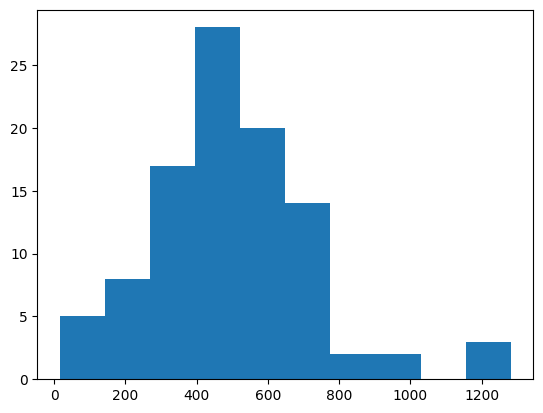

In [15]:
import matplotlib.pyplot as plt 

plt.hist([len(clip_partition[label]) for label in clip_partition.keys()])